In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/m5-forecasting-accuracy.zip

Archive:  /content/drive/MyDrive/m5-forecasting-accuracy.zip
  inflating: calendar.csv            
  inflating: sales_train_evaluation.csv  
  inflating: sales_train_validation.csv  
  inflating: sample_submission.csv   
  inflating: sell_prices.csv         


In [ ]:
# ============================================================
# CELLULE 2 : Import des bibliothèques
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU Available: []


In [ ]:
# ============================================================
# CELLULE 3 : Chargement des données originales
# ============================================================
# Ajustez les chemins selon votre emplacement de fichiers
sales_train = pd.read_csv('sales_train_validation.csv')
calendar = pd.read_csv('calendar.csv')
sell_prices = pd.read_csv('sell_prices.csv')

print(f"Sales Train Shape: {sales_train.shape}")
print(f"Calendar Shape: {calendar.shape}")
print(f"Sell Prices Shape: {sell_prices.shape}")


Sales Train Shape: (30490, 1919)
Calendar Shape: (1969, 14)
Sell Prices Shape: (6841121, 4)


In [ ]:
# ============================================================
# CELLULE 4 : Réduction - Sélection de 50 articles aléatoires
# ============================================================
# Fixer la seed pour la reproductibilité
np.random.seed(42)

# Règle 1: Sélectionner 50 articles au hasard (augmenté pour meilleur apprentissage)
random_items = np.random.choice(sales_train['id'].values, size=50, replace=False)
sales_reduced = sales_train[sales_train['id'].isin(random_items)].copy()

print(f"✓ {len(random_items)} articles sélectionnés aléatoirement")
print(f"Shape après réduction: {sales_reduced.shape}")
print(f"\nPremiers articles: {random_items[:5]}...")
print(f"Derniers articles: ...{random_items[-5:]}")

✓ 50 articles sélectionnés aléatoirement
Shape après réduction: (50, 1919)

Premiers articles: ['FOODS_3_180_CA_1_validation' 'HOUSEHOLD_2_383_CA_3_validation'
 'FOODS_3_409_CA_3_validation' 'FOODS_1_097_CA_2_validation'
 'HOBBIES_1_272_TX_2_validation']...
Derniers articles: ...['HOUSEHOLD_2_359_TX_2_validation' 'FOODS_2_212_WI_3_validation'
 'FOODS_3_507_TX_2_validation' 'HOBBIES_2_005_WI_3_validation'
 'FOODS_3_009_CA_3_validation']


In [ ]:
# ============================================================
# CELLULE 5 : Réduction - Garder 180 premiers jours (6 mois)
# ============================================================
# Règle 2: Garder d_1 à d_180 (6 mois de données)
day_cols = [f'd_{i}' for i in range(1, 181)]
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

sales_reduced = sales_reduced[id_cols + day_cols]
print(f"✓ Sales avec 180 jours: {sales_reduced.shape}")
print(f"  - Articles: {len(sales_reduced)}")
print(f"  - Colonnes de jours: {len(day_cols)}")
print(f"  - Total points de données: {len(sales_reduced) * len(day_cols):,}")
print(f"\nAperçu des données:")
print(sales_reduced.head())

✓ Sales avec 180 jours: (50, 186)
  - Articles: 50
  - Colonnes de jours: 180
  - Total points de données: 9,000

Aperçu des données:
                                   id          item_id      dept_id  \
96      HOBBIES_1_100_CA_1_validation    HOBBIES_1_100    HOBBIES_1   
279     HOBBIES_1_287_CA_1_validation    HOBBIES_1_287    HOBBIES_1   
762   HOUSEHOLD_1_202_CA_1_validation  HOUSEHOLD_1_202  HOUSEHOLD_1   
1092  HOUSEHOLD_1_537_CA_1_validation  HOUSEHOLD_1_537  HOUSEHOLD_1   
2208      FOODS_2_382_CA_1_validation      FOODS_2_382      FOODS_2   

         cat_id store_id state_id  d_1  d_2  d_3  d_4  ...  d_171  d_172  \
96      HOBBIES     CA_1       CA    1    2    2    1  ...      1      0   
279     HOBBIES     CA_1       CA    0    0    0    0  ...      0      0   
762   HOUSEHOLD     CA_1       CA    0    0    0    0  ...      0      0   
1092  HOUSEHOLD     CA_1       CA    3    1    1    0  ...      2      1   
2208      FOODS     CA_1       CA    2    1    1    1  ... 

In [ ]:
# ============================================================
# CELLULE 6 : Réduction du calendrier aux 180 jours
# ============================================================
# Règle 3: Réduire le calendrier aux 180 jours sélectionnés
calendar_reduced = calendar[calendar['d'].isin(day_cols)].copy()
print(f"✓ Calendrier réduit: {calendar_reduced.shape}")
print(f"  - Plage de dates: {calendar_reduced['date'].min()} à {calendar_reduced['date'].max()}")

# Calculer la durée
date_range = pd.to_datetime(calendar_reduced['date'].max()) - pd.to_datetime(calendar_reduced['date'].min())
print(f"  - Durée couverte: {date_range.days} jours (~{date_range.days/30:.1f} mois)")

# Obtenir les semaines uniques pour filtrer les prix
unique_weeks = calendar_reduced['wm_yr_wk'].unique()
print(f"  - Semaines uniques: {len(unique_weeks)}")

✓ Calendrier réduit: (180, 14)
  - Plage de dates: 2011-01-29 à 2011-07-27
  - Durée couverte: 179 jours (~6.0 mois)
  - Semaines uniques: 26


In [ ]:
# ============================================================
# CELLULE 7 : Réduction des prix de vente
# ============================================================
# Règle 4: Réduire les prix aux semaines et articles sélectionnés
sell_prices_reduced = sell_prices[
    (sell_prices['wm_yr_wk'].isin(unique_weeks)) &
    (sell_prices['item_id'].isin(sales_reduced['item_id'].values))
].copy()

print(f"Prix réduits: {sell_prices_reduced.shape}")
print(f"\nAperçu:")
print(sell_prices_reduced.head())

Prix réduits: (5154, 4)

Aperçu:
     store_id        item_id  wm_yr_wk  sell_price
5119     CA_1  HOBBIES_1_022     11101        6.86
5120     CA_1  HOBBIES_1_022     11102        6.86
5121     CA_1  HOBBIES_1_022     11103        6.86
5122     CA_1  HOBBIES_1_022     11104        6.86
5123     CA_1  HOBBIES_1_022     11105        6.86


In [ ]:
# ============================================================
# CELLULE 8 : Sauvegarde des datasets réduits
# ============================================================
sales_reduced.to_csv('sales_train_reduced.csv', index=False)
calendar_reduced.to_csv('calendar_reduced.csv', index=False)
sell_prices_reduced.to_csv('sell_prices_reduced.csv', index=False)

print("✓ Datasets réduits sauvegardés!")
print(f"\n📊 Résumé de la réduction:")
print(f"  - Articles: {len(sales_train):,} → {len(sales_reduced)} (×{len(sales_reduced)/len(sales_train)*100:.1f}%)")
print(f"  - Jours: 1913 → 180 (~6 mois)")
print(f"  - Calendrier: {len(calendar):,} → {len(calendar_reduced)}")
print(f"  - Prix: {len(sell_prices):,} → {len(sell_prices_reduced):,}")
print(f"\n💾 Taille totale des données:")
print(f"  - Points de ventes: {len(sales_reduced) * 180:,}")
print(f"  - Idéal pour entraînement RNN/LSTM/GRU ✅")


✓ Datasets réduits sauvegardés!

📊 Résumé de la réduction:
  - Articles: 30,490 → 50 (×0.2%)
  - Jours: 1913 → 180 (~6 mois)
  - Calendrier: 1,969 → 180
  - Prix: 6,841,121 → 5,154

💾 Taille totale des données:
  - Points de ventes: 9,000
  - Idéal pour entraînement RNN/LSTM/GRU ✅


In [ ]:
# ============================================================
# CELLULE 9 : Transformation en format série temporelle
# ============================================================
# Transformer en format long pour l'analyse
sales_melted = sales_reduced.melt(
    id_vars=id_cols,
    value_vars=day_cols,
    var_name='d',
    value_name='sales'
)

# Fusionner avec le calendrier
sales_ts = sales_melted.merge(calendar_reduced, on='d', how='left')
sales_ts['date'] = pd.to_datetime(sales_ts['date'])
sales_ts = sales_ts.sort_values(['id', 'date']).reset_index(drop=True)

print(f"Données en série temporelle: {sales_ts.shape}")
print(sales_ts.head(10))


Données en série temporelle: (9000, 21)
                            id      item_id  dept_id cat_id store_id state_id  \
0  FOODS_1_049_TX_2_validation  FOODS_1_049  FOODS_1  FOODS     TX_2       TX   
1  FOODS_1_049_TX_2_validation  FOODS_1_049  FOODS_1  FOODS     TX_2       TX   
2  FOODS_1_049_TX_2_validation  FOODS_1_049  FOODS_1  FOODS     TX_2       TX   
3  FOODS_1_049_TX_2_validation  FOODS_1_049  FOODS_1  FOODS     TX_2       TX   
4  FOODS_1_049_TX_2_validation  FOODS_1_049  FOODS_1  FOODS     TX_2       TX   
5  FOODS_1_049_TX_2_validation  FOODS_1_049  FOODS_1  FOODS     TX_2       TX   
6  FOODS_1_049_TX_2_validation  FOODS_1_049  FOODS_1  FOODS     TX_2       TX   
7  FOODS_1_049_TX_2_validation  FOODS_1_049  FOODS_1  FOODS     TX_2       TX   
8  FOODS_1_049_TX_2_validation  FOODS_1_049  FOODS_1  FOODS     TX_2       TX   
9  FOODS_1_049_TX_2_validation  FOODS_1_049  FOODS_1  FOODS     TX_2       TX   

      d  sales       date  wm_yr_wk  ... wday  month  year  event_na

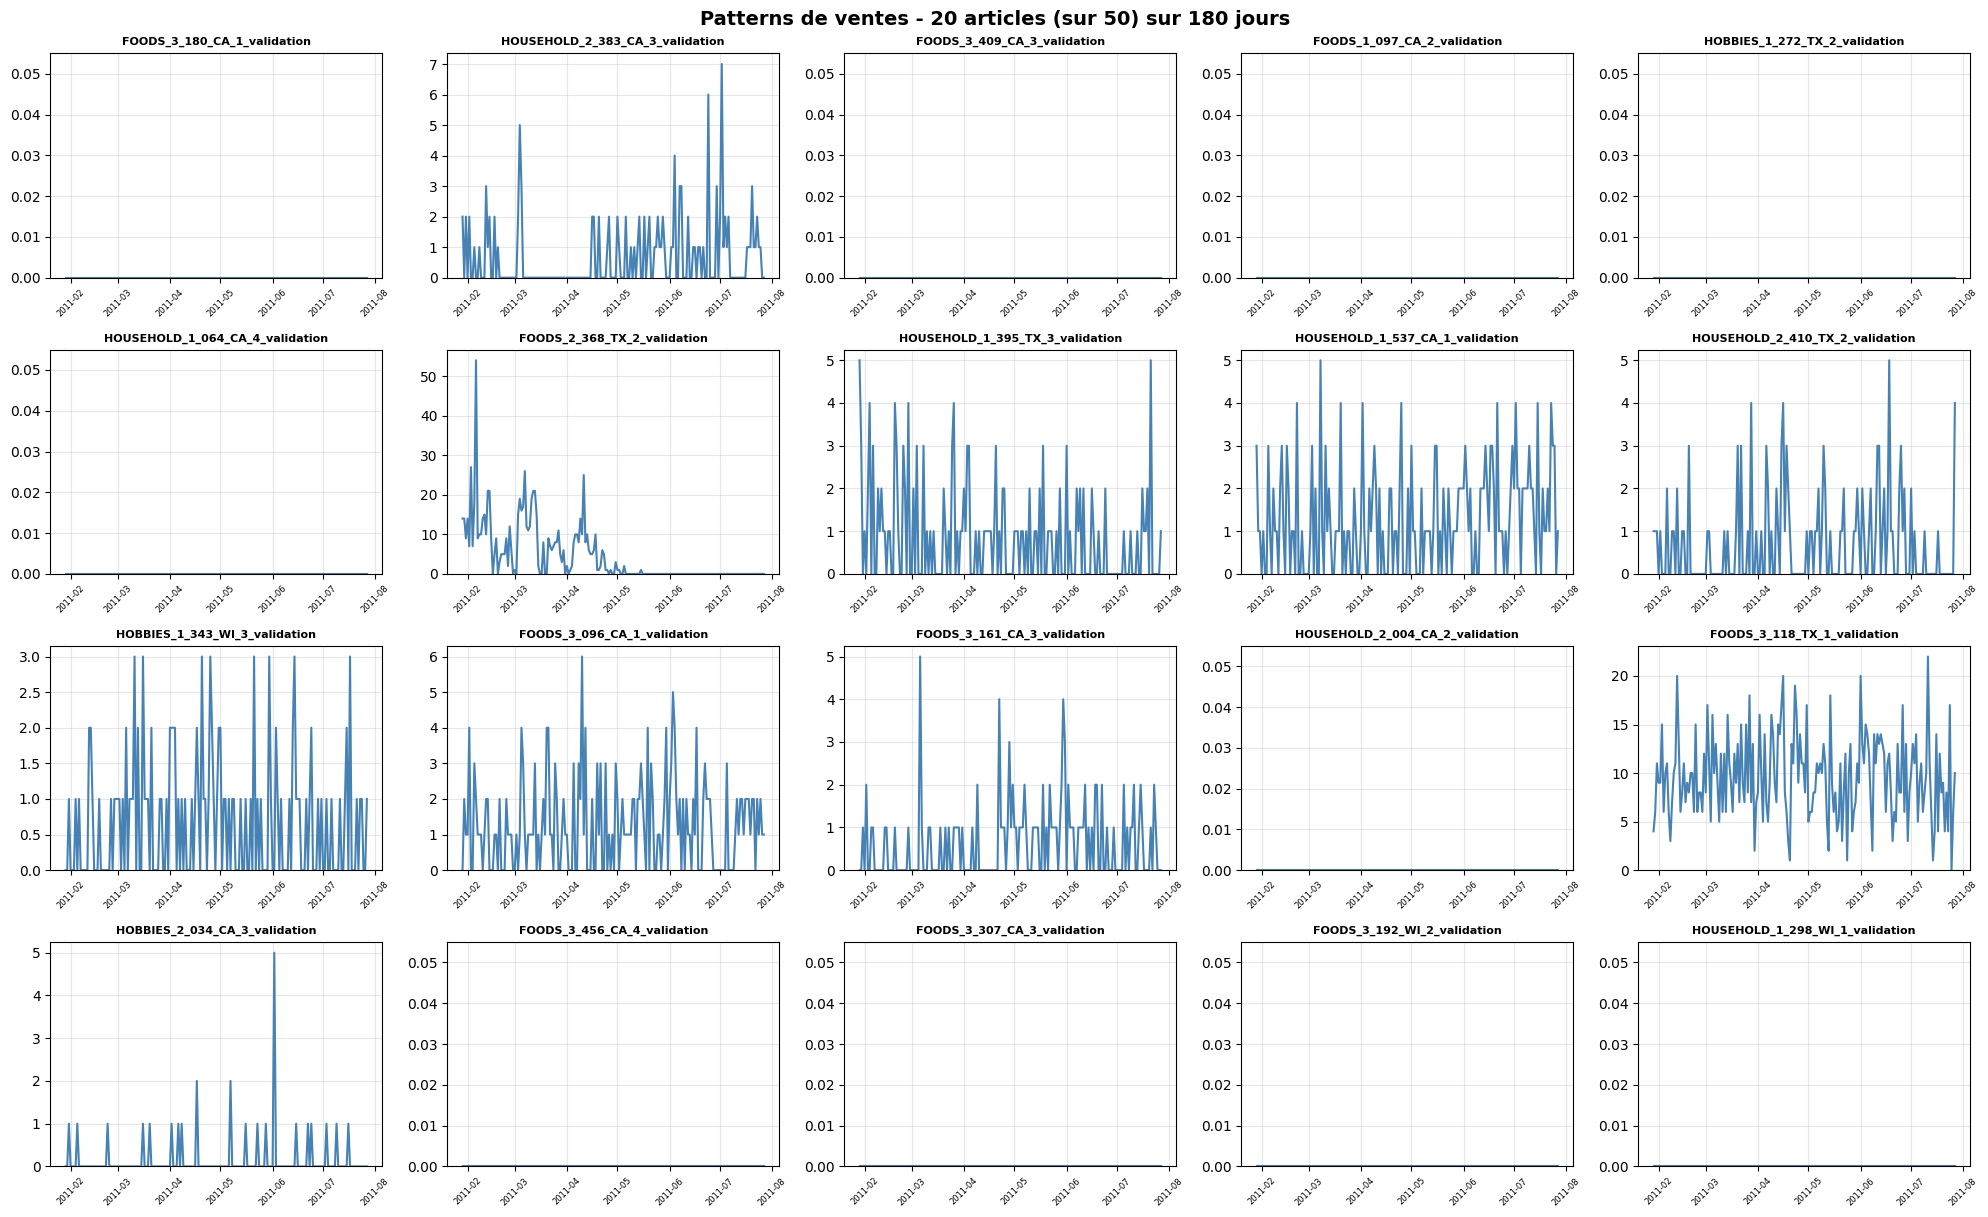


📊 Statistiques des ventes:
  - Ventes moyennes: 0.67
  - Ventes médianes: 0.00
  - Max: 54, Min: 0


In [ ]:
# ============================================================
# CELLULE 10 : Visualisation des patterns de vente
# ============================================================
# Visualiser un échantillon de 20 articles (sur les 50)
sample_items = random_items[:20]  # Prendre les 20 premiers

fig, axes = plt.subplots(4, 5, figsize=(20, 12))
axes = axes.flatten()

for idx, item_id in enumerate(sample_items):
    item_data = sales_ts[sales_ts['id'] == item_id]
    axes[idx].plot(item_data['date'], item_data['sales'], linewidth=1.5, color='steelblue')
    axes[idx].set_title(f"{item_id}", fontsize=8, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45, labelsize=6)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(bottom=0)

plt.tight_layout()
plt.suptitle('Patterns de ventes - 20 articles (sur 50) sur 180 jours',
             y=1.01, fontsize=14, fontweight='bold')
plt.show()

print(f"\n📊 Statistiques des ventes:")
print(f"  - Ventes moyennes: {sales_ts['sales'].mean():.2f}")
print(f"  - Ventes médianes: {sales_ts['sales'].median():.2f}")
print(f"  - Max: {sales_ts['sales'].max():.0f}, Min: {sales_ts['sales'].min():.0f}")


In [ ]:
# ============================================================
# CELLULE 11 : Fonction pour créer les séquences
# ============================================================
def create_sequences(data, lookback=7, forecast_horizon=1):
    """
    Créer des séquences pour la prédiction de séries temporelles

    Args:
        data: array des valeurs de ventes
        lookback: nombre de jours passés à utiliser comme input
        forecast_horizon: nombre de jours à prédire

    Returns:
        X: données d'entrée (lookback jours)
        y: données de sortie (jours à prédire)
    """
    X, y = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+forecast_horizon])
    return np.array(X), np.array(y)

print("✓ Fonction create_sequences définie")

✓ Fonction create_sequences définie


In [ ]:
# ============================================================
# CELLULE 12 : Préparation des données pour l'entraînement
# ============================================================
# Paramètres optimisés pour 180 jours
LOOKBACK = 14  # Utiliser 14 jours (2 semaines) pour capturer plus de patterns
FORECAST_HORIZON = 1  # Prédire 1 jour
TRAIN_SPLIT = 0.8  # 80% train, 20% test

print(f"⚙️ Configuration:")
print(f"  - Lookback: {LOOKBACK} jours")
print(f"  - Forecast horizon: {FORECAST_HORIZON} jour")
print(f"  - Train/Test split: {TRAIN_SPLIT*100:.0f}%/{(1-TRAIN_SPLIT)*100:.0f}%")

# Préparer les données pour chaque article
all_X_train, all_y_train = [], []
all_X_test, all_y_test = [], []
scalers = {}

print(f"\n🔄 Traitement de {len(random_items)} articles...")

for idx, item_id in enumerate(random_items):
    # Récupérer les ventes de l'article
    item_sales = sales_ts[sales_ts['id'] == item_id]['sales'].values.reshape(-1, 1)

    # Normaliser les données (important pour les réseaux de neurones!)
    scaler = MinMaxScaler()
    item_sales_scaled = scaler.fit_transform(item_sales)
    scalers[item_id] = scaler

    # Créer les séquences
    X, y = create_sequences(item_sales_scaled.flatten(), LOOKBACK, FORECAST_HORIZON)

    # Split train/test
    split_idx = int(len(X) * TRAIN_SPLIT)

    all_X_train.append(X[:split_idx])
    all_y_train.append(y[:split_idx])
    all_X_test.append(X[split_idx:])
    all_y_test.append(y[split_idx:])

    if (idx + 1) % 10 == 0:
        print(f"  ✓ {idx + 1}/{len(random_items)} articles traités")

# Combiner tous les articles
X_train = np.concatenate(all_X_train, axis=0)
y_train = np.concatenate(all_y_train, axis=0)
X_test = np.concatenate(all_X_test, axis=0)
y_test = np.concatenate(all_y_test, axis=0)

print(f"\n✅ Données préparées!")
print(f"  📈 Train: X={X_train.shape}, y={y_train.shape}")
print(f"  📊 Test:  X={X_test.shape}, y={y_test.shape}")
print(f"\n💡 Total séquences: {len(X_train) + len(X_test):,}")
print(f"   → Excellent pour l'apprentissage des modèles RNN! ✅")


⚙️ Configuration:
  - Lookback: 14 jours
  - Forecast horizon: 1 jour
  - Train/Test split: 80%/20%

🔄 Traitement de 50 articles...
  ✓ 10/50 articles traités
  ✓ 20/50 articles traités
  ✓ 30/50 articles traités
  ✓ 40/50 articles traités
  ✓ 50/50 articles traités

✅ Données préparées!
  📈 Train: X=(6600, 14), y=(6600, 1)
  📊 Test:  X=(1700, 14), y=(1700, 1)

💡 Total séquences: 8,300
   → Excellent pour l'apprentissage des modèles RNN! ✅


In [ ]:
# ============================================================
# CELLULE 13 : Reshape pour les modèles RNN/LSTM/GRU
# ============================================================
# Les modèles récurrents ont besoin de: (samples, timesteps, features)
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"✅ Shape pour RNN/LSTM/GRU: {X_train_rnn.shape}")
print(f"  - Samples (séquences): {X_train_rnn.shape[0]:,}")
print(f"  - Timesteps (lookback): {X_train_rnn.shape[1]}")
print(f"  - Features: {X_train_rnn.shape[2]}")

print(f"\n📊 Ratio données/paramètres:")
print(f"  - Séquences d'entraînement: {X_train_rnn.shape[0]:,}")
print(f"  - Typique modèle LSTM params: ~13,000")
print(f"  - Ratio: {X_train_rnn.shape[0]/13000:.1f}:1")
if X_train_rnn.shape[0] > 5000:
    print(f"  ✅ Excellent ratio! Faible risque d'overfitting")
elif X_train_rnn.shape[0] > 2000:
    print(f"  ✅ Bon ratio pour l'apprentissage")
else:
    print(f"  ⚠️ Ratio faible, considérez plus de données")

✅ Shape pour RNN/LSTM/GRU: (6600, 14, 1)
  - Samples (séquences): 6,600
  - Timesteps (lookback): 14
  - Features: 1

📊 Ratio données/paramètres:
  - Séquences d'entraînement: 6,600
  - Typique modèle LSTM params: ~13,000
  - Ratio: 0.5:1
  ✅ Excellent ratio! Faible risque d'overfitting


In [ ]:
# ============================================================
# CELLULE 14 : Fonction d'évaluation
# ============================================================
def evaluate_model(model, X_test, y_test, history, model_name, color):
    """
    Évaluer un modèle et afficher métriques + graphiques
    """
    print("\n" + "="*70)
    print(f" "*20 + f"📊 ÉVALUATION : {model_name.upper()}")
    print("="*70)

    # Prédictions
    predictions = model.predict(X_test, verbose=0)

    # Calculer métriques
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)

    # Calculer MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test - predictions) / (y_test + 1e-10))) * 100

    # Afficher métriques
    print(f"\n📈 Métriques de performance:")
    print(f"  • MSE  (Mean Squared Error)        : {mse:.6f}")
    print(f"  • RMSE (Root Mean Squared Error)   : {rmse:.6f}")
    print(f"  • MAE  (Mean Absolute Error)       : {mae:.6f}")
    print(f"  • MAPE (Mean Abs Percentage Error) : {mape:.2f}%")

    # Créer graphiques
    fig = plt.figure(figsize=(16, 5))

    # Graphique 1: Loss d'entraînement
    plt.subplot(1, 3, 1)
    epochs_trained = len(history.history['loss'])
    plt.plot(history.history['loss'], label='Train Loss', color=color, linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', color=color,
             linewidth=2, linestyle='--', alpha=0.7)
    plt.title(f'{model_name} - Loss ({epochs_trained} epochs)', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Graphique 2: Prédictions vs Réalité (échantillon plus grand)
    plt.subplot(1, 3, 2)
    sample_size = min(100, len(y_test))  # Montrer plus de points
    plt.plot(y_test[:sample_size], label='Valeurs Réelles',
             marker='o', markersize=3, linewidth=1.5, color='black', alpha=0.7)
    plt.plot(predictions[:sample_size], label='Prédictions',
             marker='x', markersize=3, linewidth=1.5, color=color)
    plt.title(f'{model_name} - Prédictions vs Réalité', fontsize=12, fontweight='bold')
    plt.xlabel('Échantillon')
    plt.ylabel('Ventes (normalisées)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Graphique 3: Distribution des erreurs
    plt.subplot(1, 3, 3)
    errors = (y_test.flatten() - predictions.flatten())
    plt.hist(errors, bins=30, color=color, alpha=0.6, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erreur nulle')
    plt.axvline(x=np.mean(errors), color='green', linestyle='--', linewidth=2,
                label=f'Moyenne: {np.mean(errors):.4f}')
    plt.title(f'{model_name} - Distribution des erreurs', fontsize=12, fontweight='bold')
    plt.xlabel('Erreur de prédiction')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    print("="*70)

    return {
        'Modèle': model_name,
        'MSE': round(mse, 6),
        'RMSE': round(rmse, 6),
        'MAE': round(mae, 6),
        'MAPE': round(mape, 2),
        'Epochs': epochs_trained
    }

print("✓ Fonction d'évaluation définie (avec MAPE et distribution d'erreurs)")


✓ Fonction d'évaluation définie (avec MAPE et distribution d'erreurs)


In [ ]:
# ============================================================
# CELLULE 15 : Early Stopping callback
# ============================================================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Augmenté de 10 à 15 pour plus de données
    restore_best_weights=True,
    verbose=1
)

print("✓ Early Stopping configuré")
print(f"  - Monitor: val_loss")
print(f"  - Patience: 15 epochs (augmentée pour dataset plus grand)")
print(f"  - Restore best weights: Oui")

# Initialiser le dictionnaire pour stocker tous les résultats
all_results = []

✓ Early Stopping configuré
  - Monitor: val_loss
  - Patience: 15 epochs (augmentée pour dataset plus grand)
  - Restore best weights: Oui



🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷
🚀 CONSTRUCTION ET ENTRAÎNEMENT : SIMPLE RNN
🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷

📋 Architecture du modèle:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 14, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,951 (34.96 KB)

 Trainable params: 8,951 (34.96 KB)

 Non-trainable params: 0 (0.00 B)


⏳ Entraînement en cours...
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0261 - mae: 0.0886 - val_loss: 0.0146 - val_mae: 0.0485
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0220 - mae: 0.0803 - val_loss: 0.0132 - val_mae: 0.0527
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0206 - mae: 0.0767 - val_loss: 0.0136 - val_mae: 0.0642
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0210 - mae: 0.0764 - val_loss: 0.0148 - val_mae: 0.0655
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0213 - mae: 0.0765 - val_loss: 0.0131 - val_mae: 0.0528
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0199 - mae: 0.0739 - val_loss: 0.0134 - val_mae: 0.0581
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0226 - mae: 0.0798 - val_loss: 0.0131 - val_mae: 0.0565
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0208 - mae: 0.0731 - val_loss: 0.0135 - val_mae: 0.0545
Epoch 9/100
165/16

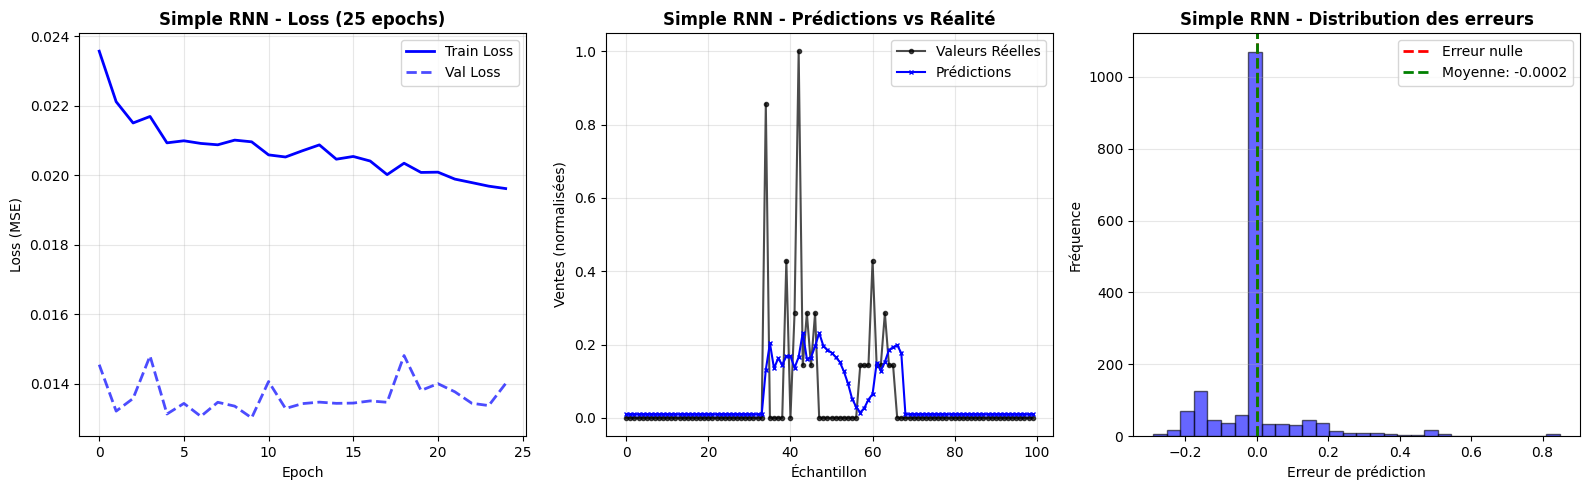

In [ ]:
# ============================================================
# CELLULE 16 : MODÈLE 1 - Simple RNN
# ============================================================
print("\n" + "🔷"*35)
print("🚀 CONSTRUCTION ET ENTRAÎNEMENT : SIMPLE RNN")
print("🔷"*35)

# Construction
model_rnn = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(LOOKBACK, 1), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(FORECAST_HORIZON)
])

model_rnn.compile(optimizer='adam', loss='mse', metrics=['mae'])
print("\n📋 Architecture du modèle:")
model_rnn.summary()

# Entraînement
print("\n⏳ Entraînement en cours...")
history_rnn = model_rnn.fit(
    X_train_rnn, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Évaluation immédiate
results_rnn = evaluate_model(model_rnn, X_test_rnn, y_test, history_rnn, 'Simple RNN', 'blue')
all_results.append(results_rnn)


🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶
🚀 CONSTRUCTION ET ENTRAÎNEMENT : LSTM
🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶🔶

📋 Architecture du modèle:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)


⏳ Entraînement en cours...
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0257 - mae: 0.0961 - val_loss: 0.0142 - val_mae: 0.0604
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0229 - mae: 0.0836 - val_loss: 0.0139 - val_mae: 0.0547
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0217 - mae: 0.0785 - val_loss: 0.0137 - val_mae: 0.0655
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0202 - mae: 0.0759 - val_loss: 0.0135 - val_mae: 0.0575
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0213 - mae: 0.0792 - val_loss: 0.0138 - val_mae: 0.0595
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0204 - mae: 0.0748 - val_loss: 0.0134 - val_mae: 0.0576
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0211 - mae: 0.0770 - val_loss: 0.0134 - val_mae: 0.0609
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0212 - mae: 0.0777 - val_loss: 0.0137 - val_mae: 0.0562
Epoch 9/100


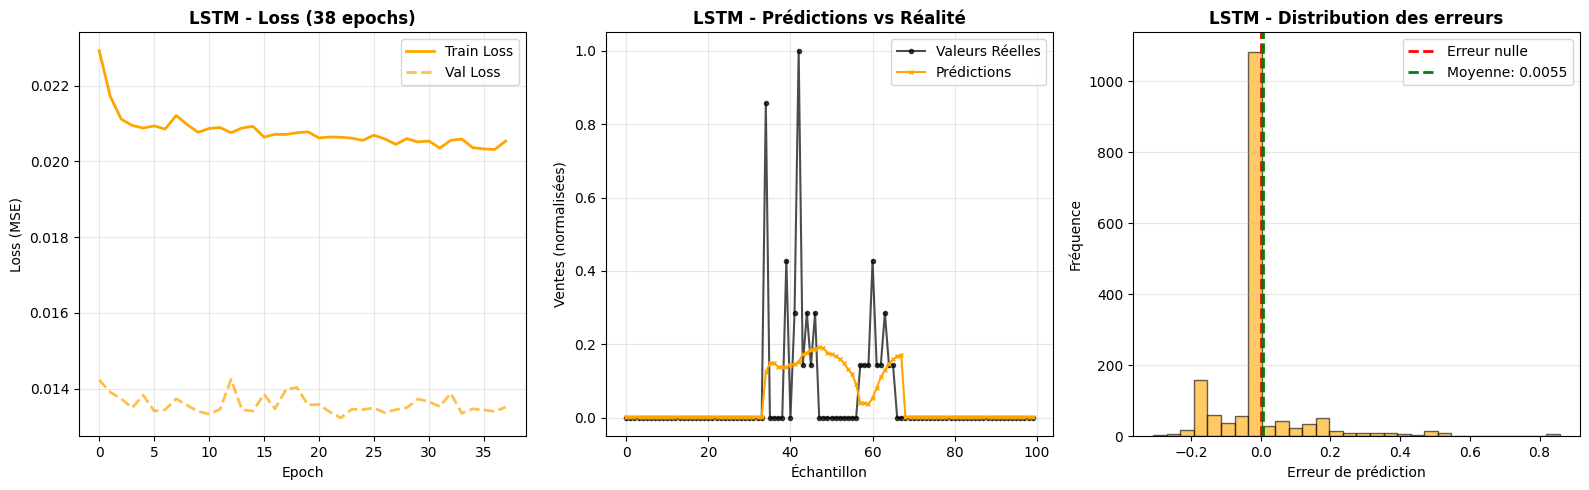

In [ ]:
# ============================================================
# CELLULE 17 : MODÈLE 2 - LSTM
# ============================================================
print("\n" + "🔶"*35)
print("🚀 CONSTRUCTION ET ENTRAÎNEMENT : LSTM")
print("🔶"*35)

# Construction
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(LOOKBACK, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(FORECAST_HORIZON)
])

model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
print("\n📋 Architecture du modèle:")
model_lstm.summary()

# Entraînement
print("\n⏳ Entraînement en cours...")
history_lstm = model_lstm.fit(
    X_train_rnn, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Évaluation immédiate
results_lstm = evaluate_model(model_lstm, X_test_rnn, y_test, history_lstm, 'LSTM', 'orange')
all_results.append(results_lstm)


🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢
🚀 CONSTRUCTION ET ENTRAÎNEMENT : GRU
🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢

📋 Architecture du modèle:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 14, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)


⏳ Entraînement en cours...
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0241 - mae: 0.0916 - val_loss: 0.0136 - val_mae: 0.0517
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0208 - mae: 0.0734 - val_loss: 0.0141 - val_mae: 0.0659
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0208 - mae: 0.0770 - val_loss: 0.0135 - val_mae: 0.0526
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0209 - mae: 0.0752 - val_loss: 0.0133 - val_mae: 0.0562
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0195 - mae: 0.0742 - val_loss: 0.0135 - val_mae: 0.0541
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0212 - mae: 0.0758 - val_loss: 0.0135 - val_mae: 0.0541
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0225 - mae: 0.0788 - val_loss: 0.0140 - val_mae: 0.0606
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0216 - mae: 0.0758 - val_loss: 0.0133 - val_mae: 0.0538
Epoch 9/100

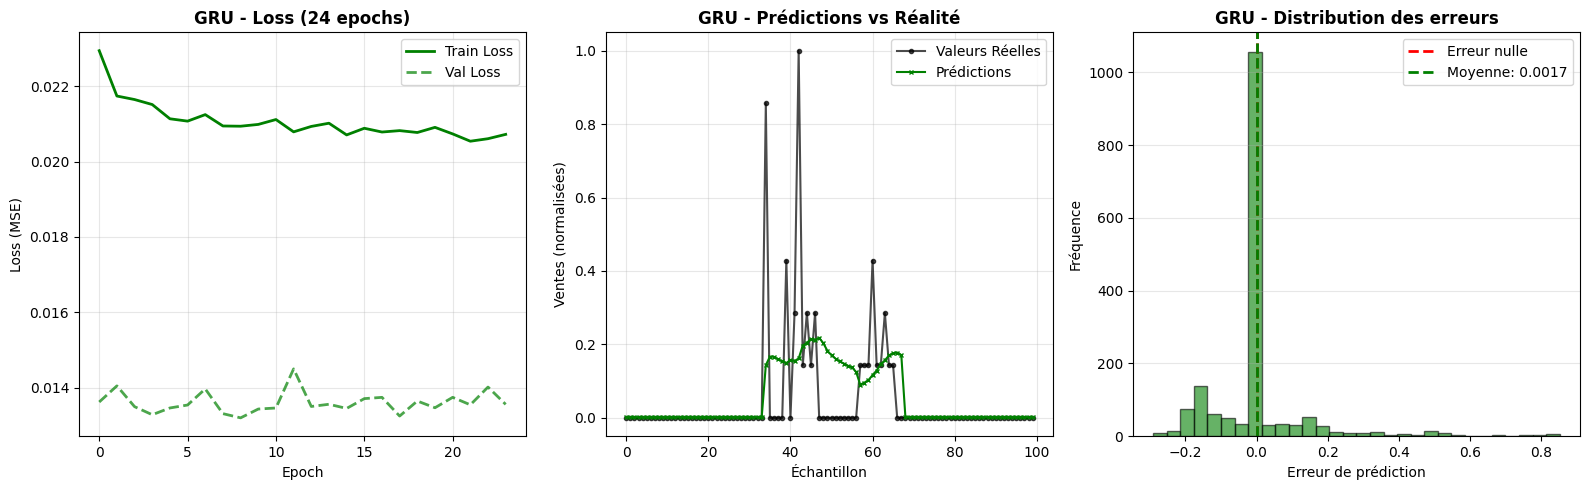

In [ ]:
# ============================================================
# CELLULE 18 : MODÈLE 3 - GRU
# ============================================================
print("\n" + "🟢"*35)
print("🚀 CONSTRUCTION ET ENTRAÎNEMENT : GRU")
print("🟢"*35)

# Construction
model_gru = Sequential([
    GRU(50, activation='relu', input_shape=(LOOKBACK, 1), return_sequences=True),
    Dropout(0.2),
    GRU(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(FORECAST_HORIZON)
])

model_gru.compile(optimizer='adam', loss='mse', metrics=['mae'])
print("\n📋 Architecture du modèle:")
model_gru.summary()

# Entraînement
print("\n⏳ Entraînement en cours...")
history_gru = model_gru.fit(
    X_train_rnn, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Évaluation immédiate
results_gru = evaluate_model(model_gru, X_test_rnn, y_test, history_gru, 'GRU', 'green')
all_results.append(results_gru)



🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴
🚀 CONSTRUCTION ET ENTRAÎNEMENT : MLP
🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴

📋 Architecture du modèle:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 100)            │         1,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,851 (30.67 KB)

 Trainable params: 7,851 (30.67 KB)

 Non-trainable params: 0 (0.00 B)


⏳ Entraînement en cours...
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0245 - mae: 0.0843 - val_loss: 0.0138 - val_mae: 0.0511
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0211 - mae: 0.0777 - val_loss: 0.0132 - val_mae: 0.0546
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0217 - mae: 0.0762 - val_loss: 0.0134 - val_mae: 0.0509
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0211 - mae: 0.0767 - val_loss: 0.0134 - val_mae: 0.0523
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0209 - mae: 0.0740 - val_loss: 0.0134 - val_mae: 0.0526
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0207 - mae: 0.0754 - val_loss: 0.0134 - val_mae: 0.0543
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0214 - mae: 0.0747 - val_loss: 0.0136 - val_mae: 0.0545
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0208 - mae: 0.0763 - val_loss: 0.0133 - val_mae: 0.0528
Epoch 9/100
165/165 

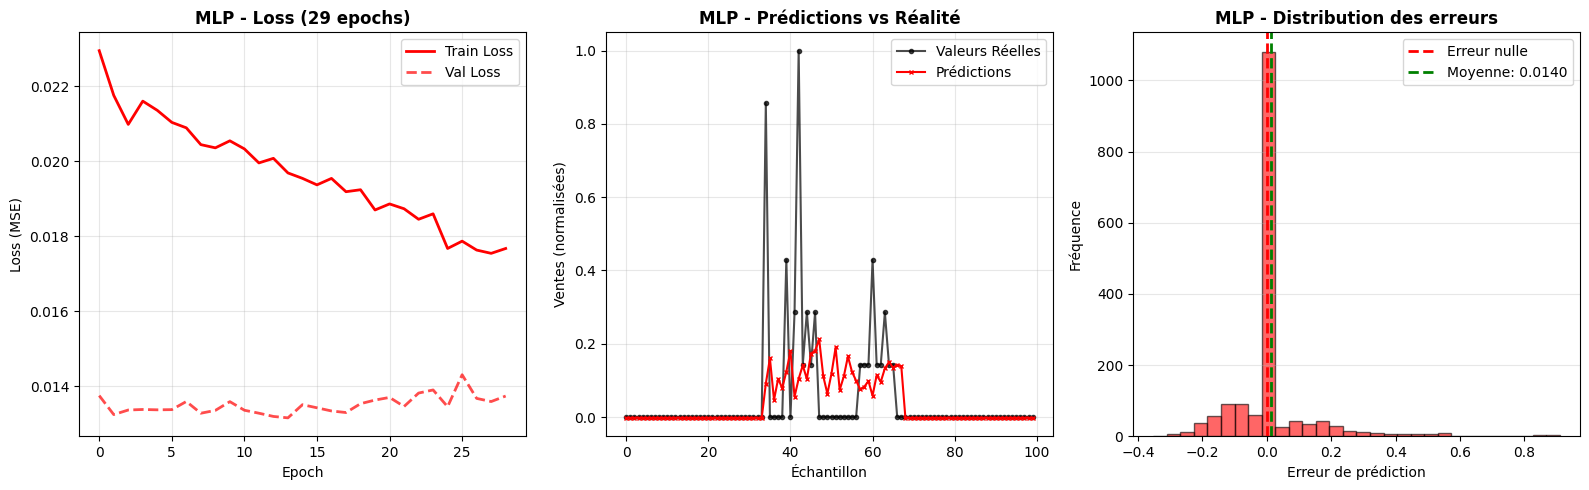

In [ ]:
# ============================================================
# CELLULE 19 : MODÈLE 4 - MLP
# ============================================================
print("\n" + "🔴"*35)
print("🚀 CONSTRUCTION ET ENTRAÎNEMENT : MLP")
print("🔴"*35)

# Construction
model_mlp = Sequential([
    Dense(100, activation='relu', input_shape=(LOOKBACK,)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(FORECAST_HORIZON)
])

model_mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])
print("\n📋 Architecture du modèle:")
model_mlp.summary()

# Entraînement
print("\n⏳ Entraînement en cours...")
history_mlp = model_mlp.fit(
    X_train, y_train,  # MLP utilise X_train (pas X_train_rnn)
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Évaluation immédiate
results_mlp = evaluate_model(model_mlp, X_test, y_test, history_mlp, 'MLP', 'red')
all_results.append(results_mlp)